<a href="https://colab.research.google.com/github/yulee-research/ImageGraph/blob/Try01/aortaTry01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

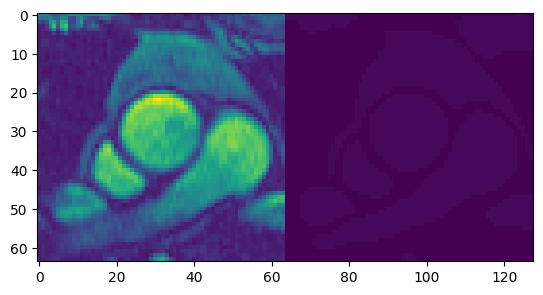

In [5]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

aortaData=loadmat('/content/drive/MyDrive/ImageGraph/aortaMag1Ph10Pt150.mat')
# print(aortaData['roiMagC1'].astype(float).dtype)
ImgC=np.array(aortaData['roiMagC'],dtype=np.float32)
ImgM=np.array(aortaData['roiMask'],dtype=np.float32)
plt.imshow(np.concatenate((ImgC,np.sum(ImgM,axis=2)),axis=1))
# roiMagC=np.zeros((371,64,64,30))
# roiPhaC=np.zeros((371,64,64,30))
# roiMask=np.zeros((371,64,64,30))

# roiMagC=tf.convert_to_tensor(np.transpose(np.concatenate((aortaData['roiMagC1'],aortaData['roiMagC2']),axis=3),(3,0,1,2)),dtype=tf.float32)
# roiPhaC=tf.convert_to_tensor(np.transpose(np.concatenate((aortaData['roiPhaC1'],aortaData['roiPhaC2']),axis=3),(3,0,1,2)),dtype=tf.float32)
# roiMask=tf.convert_to_tensor(np.transpose(np.concatenate((aortaData['roiMask1'],aortaData['roiMask2']),axis=3),(3,0,1,2)),dtype=tf.float32)

# print([roiMagC.shape,roiPhaC.shape,roiMask.shape])
# plt.imshow(roiMask[:,:,10,100],cmap='gray')

# train_ds=tf.data.Dataset.from_tensor_slices((roiMagC[0:351,:,:,:],roiPhaC[0:351,:,:,:])).shuffle(100).batch(30)
# test_ds=tf.data.Dataset.from_tensor_slices((roiMagC[351:,:,:,:],roiPhaC[351:,:,:,:])).batch(20)

# for images,labels in train_ds:
#   print([tf.shape(images),tf.shape(labels)])

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Conv2D, Reshape, Concatenate, Flatten
class MyModel(Model):
  def __init__(self):
    super().__init__()
    self.conv1e=Conv2D(60, 3, activation='relu',padding='same')
    self.conv1d=Conv2D(30, 3, activation='relu',padding='same')
    self.conv0d=Conv2D(30, 1, padding='same')
    self.conv2d=Conv2D(4, 1, padding='same')
    self.flat=Flatten()
    self.resh1=Reshape((64,64,60))
    self.resh2=Reshape((16,16,4))
    self.comb=Concatenate()
    self.fcnn1e=Dense(16*16*4, activation='relu')
    self.fcnn2e=Dense(200, activation='relu')
    self.fcnn2d=Dense(16*16*4, activation='relu')
    self.fcnn1d=Dense(64*64*60, activation='relu')

  def call(self, x):
    x1e = self.conv1e(x)
    x1eF=self.flat(x1e)
    x2eF=self.fcnn1e(x1eF)
    x2e=self.resh2(x2eF)
    x3eF=self.fcnn2e(x2eF)
    x2dF=self.fcnn2d(x3eF)
    x2d=self.resh2(x2dF)
    x2dC=self.comb([x2e,x2d])
    x2dC=self.conv2d(x2dC)
    x2dCF=self.flat(x2dC)
    x1dF=self.fcnn1d(x2dCF)
    x1d=self.resh1(x1dF)
    x1dC=self.comb([x1e,x1d])
    x1dC=self.conv1d(x1dC)
    y=self.conv0d(x1dC)
    return y

# Create an instance of the model
model=MyModel()

loss_object=tf.keras.losses.MeanSquaredError(name='MeanSqureLoss')
optimizer=tf.keras.optimizers.Adam()

train_loss=tf.keras.metrics.Mean(name='TrainLoss')
test_loss=tf.keras.metrics.Mean(name='TestLoss')

@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    pred=model(images,training=True)
    loss=loss_object(labels,pred)
  gradients=tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)

@tf.function
def test_step(images,labels):
  pred=model(images,training=False)
  loss=loss_object(labels,pred)
  test_loss(loss)

  #return pred

In [ ]:
from scipy.io import savemat
# import os

# checkpointPath="/content/drive/MyDrive/aortaTrainingCheckpoint/model.ckpt"
# # os.listdir(os.path.dirname(checkpointPath))

EPOCHS=5

for epoch in range(EPOCHS):
  train_loss.reset_states()
  test_loss.reset_states()
  for images, labels in train_ds:
    #print([tf.shape(images),tf.shape(labels)])
    train_step(images, labels)

  for test_images, test_labels in test_ds:
    #print([tf.shape(test_images),tf.shape(test_labels)])
    pred=test_step(test_images, test_labels)

  print(
      f'Epoch {epoch + 1}. '
      f'Loss: {train_loss.result()}, '
      f'Test loss: {test_loss.result()}'
  )

pred=model(test_images,training=False)
testMagC=test_images.numpy()
testLabC=test_labels.numpy()
testPred=pred.numpy()
#print(testPred)
matData={"testMagC":testMagC, "testLabC":testLabC, "testPred":testPred}
savemat("/content/drive/MyDrive/test_results.mat",matData)

tf.saved_model.save(model,'/content/drive/MyDrive/aortaModel')



NameError: name 'train_loss' is not defined

In [ ]:
##tf.saved_model.save(model,'/content/drive/MyDrive/aortaModel')

# tf.saved_model.load('/content/drive/MyDrive/aortaModel')
# pred=model(test_images,training=False)
# testMagC=test_images.numpy()
# testLabC=test_labels.numpy()
# testPred=pred.numpy()
# #print(testPred)
# matData={"testMagC":testMagC, "testLabC":testLabC, "testPred":testPred}
# savemat("/content/drive/MyDrive/test_results2.mat",matData)
%pip list